# Derivatives of $\theta$ and $\phi$


In [183]:
import numpy as np
import matplotlib.pyplot as plt

## 1D FFT

In [184]:
# Grid setup
N = 128
L = 1
x = np.linspace(0, L, N, endpoint=False)

# Function definition
f = lambda x: np.sin(4 * np.pi * x) 
f_prime = lambda x: 4 * np.pi * np.cos(4 * np.pi * x)

# Compute the discrete functions
f_h = f(x)
f_prime_h = f_prime(x)

# FFT Derivative
k = np.fft.fftfreq(N, d=L/(2 * np.pi * N))
f_prime_fft_h = np.fft.ifft(1j * k * np.fft.fft(f_h)).real

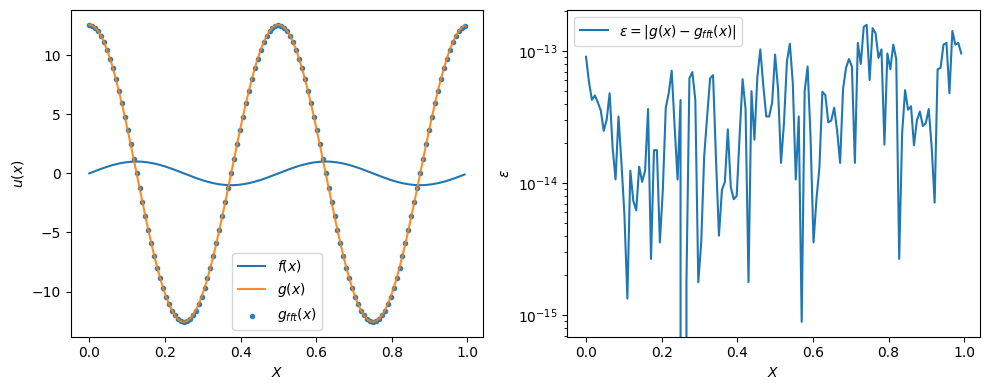

In [185]:
# plot results 
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(x, f_h, label=r'$f (x)$')
axs[0].plot(x, f_prime_h, alpha=0.9, label=r'$g (x)$')
axs[0].scatter(x, f_prime_fft_h, marker=".", alpha=0.9, label=r'$g_{fft} (x)$')
axs[0].set_xlabel(r"$X$")
axs[0].set_ylabel(r"$u(x)$")
axs[0].legend()

axs[1].semilogy(x, np.abs(f_prime_h - f_prime_fft_h), label=r'$\epsilon = |g(x) - g_{fft}(x)|$')
axs[1].set_xlabel(r"$X$")
axs[1].set_ylabel(r"$\epsilon$")

axs[1].legend()
plt.tight_layout()

plt.show()

## 2D FFT

In [186]:
# Set up grid and domain
N_phi = 128  # grid size
N_theta = N_phi // 2 + 1  # grid size
L_theta = 1  # domain size
L_phi = 1  # domain size

mesh_theta = np.linspace(0, L_theta, N_theta, endpoint=False)
mesh_phi = np.linspace(0, L_phi, N_phi, endpoint=False)
mesh = np.meshgrid(mesh_theta, mesh_phi, indexing="ij")

k_theta = np.fft.fftfreq(N_theta, d=L_theta/(2 * np.pi * N_theta))
k_phi = np.fft.fftfreq(N_phi, d=L_phi/(2 * np.pi * N_phi))
Ktheta, Kphi = np.meshgrid(k_theta, k_phi, indexing='ij')

g = lambda mesh: np.sin(4 * np.pi * mesh[0]) * np.sin(4 * np.pi * mesh[1])
g_prime_theta = lambda mesh: (
    4 * np.pi * np.cos(4 * np.pi * mesh[0]) * np.sin(4 * np.pi * mesh[1]))
g_prime_phi = lambda mesh: (
    4 * np.pi * np.cos(4 * np.pi * mesh[1]) * np.sin(4 * np.pi * mesh[0]))
g_h = g(mesh)
g_prime_theta_h = g_prime_theta(mesh)
g_prime_phi_h = g_prime_phi(mesh)

g_prime_fft2_theta_h = np.fft.ifft2(1j * Ktheta * np.fft.fft2(g_h)).real
g_prime_fft2_phi_h = np.fft.ifft2(1j * Kphi * np.fft.fft2(g_h)).real

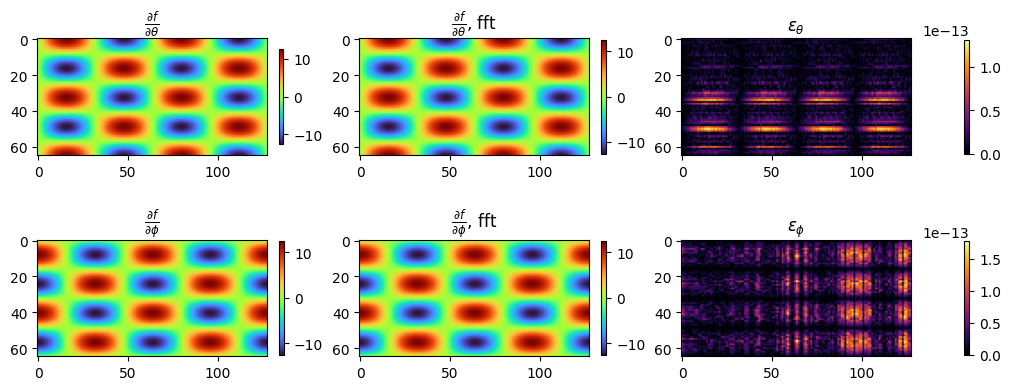

Mean error phi:  1.6363934567153887e-14
Mean error theta:  2.9112296192913396e-14


In [187]:
fig, axs = plt.subplots(2, 3, figsize=(10, 4), constrained_layout=True)

axs[0, 0].set_title(r'$\frac{\partial f}{\partial \theta}$')
g_prime_theta_bar = axs[0,0].imshow(g_prime_theta_h, cmap="turbo")

axs[0, 1].set_title(r'$\frac{\partial f}{\partial \theta}$, fft')
g_prime_fft2_theta_bar = axs[0, 1].imshow(g_prime_fft2_theta_h, cmap="turbo")

axs[0, 2].set_title(r'$\epsilon_\theta$')
im_err_theta = axs[0, 2].imshow(np.abs(g_prime_fft2_theta_h - g_prime_theta_h), cmap="inferno")

axs[1, 0].set_title(r'$\frac{\partial f}{\partial \phi}$')
g_prime_phi_bar = axs[1, 0].imshow(g_prime_phi_h, cmap="turbo")

axs[1, 1].set_title(r'$\frac{\partial f}{\partial \phi}$, fft')
g_prime_fft2_phi_bar = axs[1, 1].imshow(g_prime_fft2_phi_h, cmap="turbo")

axs[1, 2].set_title(r'$\epsilon_\phi$')
im_err_phi = axs[1, 2].imshow(np.abs(g_prime_fft2_phi_h - g_prime_phi_h), cmap="inferno")

# Add colorbars, one per column
fig.colorbar(g_prime_theta_bar, ax=axs[0, 0], shrink=0.5)
fig.colorbar(g_prime_phi_bar, ax=axs[1, 0], shrink=0.6)

fig.colorbar(g_prime_fft2_theta_bar, ax=axs[0, 1], shrink=0.6)
fig.colorbar(g_prime_fft2_phi_bar, ax=axs[1, 1], shrink=0.6)


fig.colorbar(im_err_theta, ax=axs[0, 2], shrink=0.6)
fig.colorbar(im_err_phi, ax=axs[1, 2], shrink=0.6)
#plt.tight_layout()
plt.show()

# Statistics 
print("Mean error phi: ", np.mean(np.abs(g_prime_fft2_theta_h - g_prime_theta_h)))
print("Mean error theta: ", np.mean(np.abs(g_prime_fft2_phi_h - g_prime_phi_h)))

## SHT

In [188]:
import math
import numpy as np
import torch
import torch.nn as nn

from torch_harmonics.quadrature import legendre_gauss_weights, clenshaw_curtiss_weights
from torch_harmonics.legendre import legpoly, clm
from torch_harmonics import RealSHT, InverseRealSHT
from torch_harmonics import RealVectorSHT, InverseRealVectorSHT

In [189]:
nlon = 128
nlat = nlon // 2 + 1
grid = "equiangular"
lmax = nlon // 2 + 1
mmax = nlon // 2 + 1


sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)

mesh_theta = np.linspace(0, np.pi, nlat, endpoint=False)
mesh_phi = np.linspace(0, 2 * np.pi, nlon, endpoint=False)
mesh_polar = np.meshgrid(mesh_theta, mesh_phi, indexing="ij")

l = torch.arange(lmax)
m = torch.arange(mmax)
ls = (l).reshape(-1, 1)
ms = (m).reshape(1, -1)

Ktheta, Kphi = np.meshgrid(ls, ms, indexing='ij')

e = lambda mesh: np.sin(4 * np.pi * mesh[0]) * np.sin(4 * np.pi * mesh[1])
e_prime_theta = lambda mesh: (
    4 * np.pi * np.cos(4 * np.pi * mesh[0]) * np.sin(4 * np.pi * mesh[1]))
e_prime_phi = lambda mesh: (
    4 * np.pi * np.cos(4 * np.pi * mesh[1]) * np.sin(4 * np.pi * mesh[0]))

e_h = e(mesh_polar)
e_prime_theta_h = e_prime_theta(mesh_polar)
e_prime_phi_h = e_prime_phi(mesh_polar)

e_prime_fft2_theta_h = isht(1j * torch.tensor(Ktheta) * sht(torch.tensor(e_h)))
e_prime_fft2_phi_h = isht(1j * torch.tensor(Kphi) * sht(torch.tensor(e_h)))

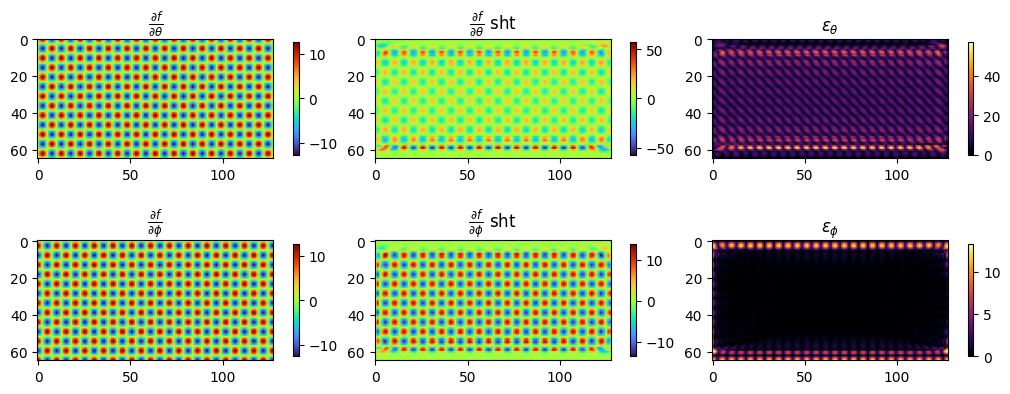

Mean error theta:  11.095667342870255
Mean error phi:  0.9485484019412784


In [190]:
fig, axs = plt.subplots(2, 3, figsize=(10,4), constrained_layout=True)

e_prime_theta_bar = axs[0, 0].imshow(e_prime_theta_h, cmap="turbo")
axs[0, 0].set_title(r'$\frac{\partial f}{\partial \theta}$')

e_prime_fft2_theta_bar = axs[0, 1].imshow(e_prime_fft2_theta_h, cmap="turbo")
axs[0, 1].set_title(r'$\frac{\partial f}{\partial \theta}$ sht')

axs[0, 2].set_title(r'$\epsilon_\theta$')
im_err_theta =axs[0, 2].imshow(np.abs(e_prime_fft2_theta_h.detach().numpy() - e_prime_theta_h), cmap="inferno")

e_prime_phi_bar = axs[1, 0].imshow(e_prime_phi_h, cmap="turbo")
axs[1, 0].set_title(r'$\frac{\partial f}{\partial \phi}$')

e_prime_fft2_phi_bar = axs[1, 1].imshow(e_prime_fft2_phi_h, cmap="turbo")
axs[1, 1].set_title(r'$\frac{\partial f}{\partial \phi}$ sht')

axs[1, 2].set_title(r'$\epsilon_\phi$')
im_err_phi = axs[1, 2].imshow(np.abs(e_prime_fft2_phi_h.detach().numpy() - e_prime_phi_h), cmap="inferno")

fig.colorbar(e_prime_theta_bar, ax=axs[0, 0], shrink=0.6)
fig.colorbar(e_prime_phi_bar, ax=axs[1, 0], shrink=0.6)

fig.colorbar(e_prime_fft2_theta_bar, ax=axs[0, 1], shrink=0.6)
fig.colorbar(e_prime_fft2_phi_bar, ax=axs[1, 1], shrink=0.6)

fig.colorbar(im_err_theta, ax=axs[0, 2], shrink=0.6)
fig.colorbar(im_err_phi, ax=axs[1, 2], shrink=0.6)

plt.show()

print("Mean error theta: ", np.mean(np.abs(e_prime_fft2_theta_h.detach().numpy() - e_prime_theta_h)))
print("Mean error phi: ", np.mean(np.abs(e_prime_fft2_phi_h.detach().numpy() - e_prime_phi_h)))